# Noisy GP Experiments

In [11]:
import numpy as np
import numba
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from sklearn.utils import check_random_state, check_array, check_X_y
from scipy.spatial.distance import pdist, cdist, squareform
from sklearn.metrics.pairwise import check_pairwise_arrays, euclidean_distances
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import _check_length_scale, WhiteKernel, RBF, ConstantKernel as C
from scipy import interpolate
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 2D Toy Example

In [14]:
figure_location = '/home/emmanuel/projects/2018_igarss/figures/noisy_gp/1d_example/'
figure_location = '/Users/eman/Documents/code_projects/gaussian_processes/pkg_sgpuppy/figures/'
figure_location = '/home/emmanuel/projects/gaussian_processes/pkg_sgpuppy/figures/'


In [15]:
weights = {}
predictions = {}
variance = {}
mae = {}
mse = {}
rmse = {}

### Sample Data

In [16]:
seed = 123
rng = np.random.RandomState(seed=seed)

# sample data parameters
x1_grid, x2_grid = 10, 10
n_train = 50

# Y Noise Covariance
sigma_y = 0.05

# X noise covariances
x1_cov = 0.0001
x2_cov = 0.1

x_cov = np.array([x1_cov, x2_cov])

x1_min, x1_max = -8.5, 8.5
x2_min, x2_max = -8.5, 8.5

x1 = np.linspace(x1_min, x1_max, x1_grid)
x2 = np.linspace(x2_min, x2_max, x2_grid)

X1, X2 = np.meshgrid(x1, x2)

X1, X2 = X1.flatten(), X2.flatten()

X = np.vstack((X1, X2)).T



x1_scale = 0.075
x2_scale = 0.5
y_scale = 0.5

# real function
f = lambda x: np.exp(x1_scale * x[:, 1]) + np.cos(x2_scale * x[:, 0])  
f = lambda x: x1_scale * x[:, 1] + np.cos(x2_scale * x[:, 0]) 
f = lambda x: np.sin(1.0 * np.pi / 1.6 * np.cos(y_scale * x[:, 0])) + x1_scale * x[:, 1]

f = lambda x: np.cos(y_scale * x[:, 0]) + x1_scale * x[:, 1]


Y = f(X)

# Add Noise

x_train = np.vstack((X1 + x1_cov * rng.randn(X1.shape[0]),
                     X2 + x2_cov * rng.randn(X2.shape[0]))).T
#X + x_cov * rng.randn(X.shape[0], X.shape[1])
y_train = Y + sigma_y * rng.randn(Y.shape[0])

y_train = y_train[:, np.newaxis]

# -----------------
# Testing Data
# -----------------
seed = 0
rng = np.random.RandomState(seed=seed)

xt1_grid, xt2_grid = 10, 10
xt1_min, xt1_max = -8, 8
xt2_min, xt2_max = -8, 8

xt1 = np.linspace(xt1_min, xt1_max, xt1_grid)
xt2 = np.linspace(xt2_min, xt2_max, xt2_grid)

Xt1, Xt2 = np.meshgrid(xt1, xt2)

Xt1, Xt2 = Xt1.flatten(), Xt2.flatten()

Xt = np.vstack((Xt1, Xt2)).T

y_test = f(Xt)

y_test = y_test[:, np.newaxis]

x_test = np.vstack((Xt1 + x1_cov * rng.randn(Xt1.shape[0]),
                    Xt2 + x2_cov * rng.randn(Xt2.shape[0]))).T


# --------------------
# Plotting Data
# --------------------
xp1_grid, xp2_grid = 20, 20
xp1_min, xp1_max = -8, 8
xp2_min, xp2_max = -8, 8

xp1 = np.linspace(xp1_min, xp1_max, xp1_grid)
xp2 = np.linspace(xp2_min, xp2_max, xp2_grid)

Xp1, Xp2 = np.meshgrid(xp1, xp2)

Xp1, Xp2 = Xp1.flatten(), Xp2.flatten()

x_plot = np.vstack((Xp1, Xp2)).T

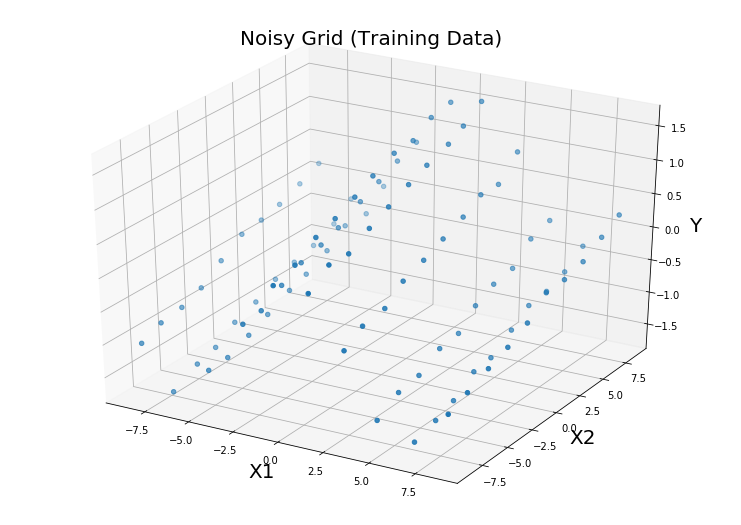

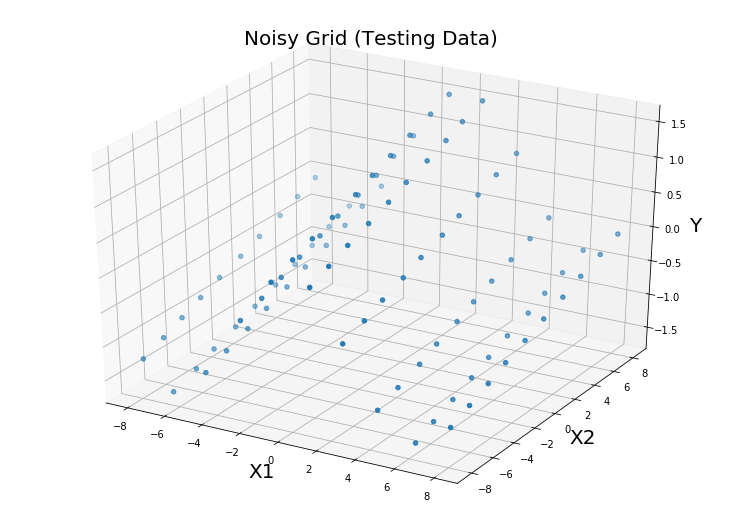

In [17]:
# ---------------------
# NOISY TRAINING DATA
# ---------------------


fig, ax = plt.subplots(figsize=(10, 7))

ax = axes3d.Axes3D(fig)

ax.scatter3D(x_train[:,0], x_train[:,1], y_train)

ax.set_title('Noisy Grid (Training Data)', fontsize=20)
ax.set_xlabel('X1', fontsize=20)
ax.set_ylabel('X2', fontsize=20)
ax.set_zlabel('Y', fontsize=20)

plt.show()

save_name = 'training_data.png'

fig.savefig(figure_location + save_name, bbox_inhces='tight')


# ---------------------
# NOISY TEST DATA
# ---------------------



fig, ax = plt.subplots(figsize=(10, 7))

ax = axes3d.Axes3D(fig)

ax.scatter3D(x_test[:,0], x_test[:, 1], y_test)

ax.set_title('Noisy Grid (Testing Data)', fontsize=20)
ax.set_xlabel('X1', fontsize=20)
ax.set_ylabel('X2', fontsize=20)
ax.set_zlabel('Y', fontsize=20)

plt.show()

save_name = 'test_data.png'

fig.savefig(figure_location + save_name, bbox_inhces='tight')

## Naive GP Implementation (to Find Suitable Hyperparameters)

In [18]:


def fit_gp(x_train, y_train, kernel='ard', scale=None,
           length_scale_bounds = (0.001, 100),
           noise_level_bounds = (1e-4, 10),
           n_restarts=3):
    
    warnings.simplefilter('ignore')
    x_train, y_train = check_X_y(x_train, y_train)
    warnings.simplefilter('default')
    n_train, d_dims = x_train.shape
    
    if kernel in ['ard', 'ARD']:
        length_scale_init = np.ones(shape=(d_dims))
    elif kernel in ['rbf', 'RBF']:
        length_scale_init = 1.0
    else:
        raise ValueError('Unrecognized kernel function...')
    
    noise_level_init = 1.0

    gp_kernel = C() * RBF(length_scale=length_scale_init,
                    length_scale_bounds=length_scale_bounds) + \
                WhiteKernel(noise_level=noise_level_init,
                            noise_level_bounds=noise_level_bounds)
    
    gpr_model = GaussianProcessRegressor(kernel=gp_kernel, random_state=123,
                                         n_restarts_optimizer=n_restarts)
    
    # Fit the GP Model
    gpr_model.fit(x_train, y_train)
    
    # the parameters
    constant = gpr_model.kernel_.get_params()['k1__k1__constant_value']
    length_scale = gpr_model.kernel_.get_params()['k1__k2__length_scale']
    sigma = gpr_model.kernel_.get_params()['k2__noise_level']
    
    return length_scale, sigma, constant

In [27]:
length_scale, sigma_y, constant = fit_gp(x_train, y_train, n_restarts=5)
print('Length Scale: {}'.format(length_scale))
print('Sigma y: {:.3f}'.format(sigma_y))
print('Likelihood Variance: {:.3f}'.format(constant))

Length Scale: [ 6.06391026 92.61654234]
Sigma y: 0.002
Likelihood Variance: 13.423


## Gaussian Covariance Function (ARD/RBF Kernel)

\begin{equation}
    K(x, y) = \nu \cdot \text{exp} \left[ -\frac{1}{2} (x - y)^{\top} \cdot W^{-1} \cdot (x - y) \right]
\end{equation}

* $W^{-1}= \text{diag}\left[ w_1, w_2, \ldots, w_{D} \right]$
* $w_d = \frac{1}{\lambda_d^2}$
* $\nu$ is the signal variance parameter

### Gaussian Derivative Term

\begin{align}
\frac{\partial \bar{f}_*}{\partial x_*} &= \frac{\partial k(x_*, X)}{\partial x_*} \cdot \alpha \\
 &= - \Lambda^{-1} \cdot \tilde{X}_*^{\top} \cdot \left( k(x_{*}, X)^{\top} \odot \alpha \right)
\end{align}

where:

* $\Lambda=\left[ \lambda_1, \lambda_2, \ldots, \lambda_D \right]$, the length scale
* $\tilde{X}_* = \left[ x_* - x_1, x_* - x_2, \ldots, x_* - x_N \right]^{\top} \in \mathcal{R}^{N \times D}$ 
* $\odot$ is the element-wise (hadamard) product.

## Standard GP

In [28]:
from GaussianProcess import GaussianProcess
from Covariance import GaussianCovariance

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [29]:
# The regression step is pretty easy:
# Input data x (list of input vectors)
# Corresponding simulation output t (just a list of floats of the same length as x)
# Covariance function of your choice (only GaussianCovariance can be used for uncertainty propagation at the moment)
gp_est = GaussianProcess(x_train, y_train, GaussianCovariance());

[-0.48457061 -1.87086497 -4.28017388 -4.30558695]
l_bfgs_b 	 4.134978532791138 	 [[-118.65945392]] 	 [ 2.63298379 -6.06483918 -3.61105307 -9.08735455]
[ 2.63298379 -6.06483918 -3.61105307 -9.08735455]


In [30]:
signal_variance = np.exp(2.63298379)
sigma_y = np.exp(-6.06483918)
length_scale = np.exp([-3.61105307, -9.08735455])
print('Length Scale: {}'.format(length_scale))
print('Likelihood Variance: {:.3f}'.format(sigma_y))
print('Signal Variance: {:.3f}'.format(signal_variance))

Length Scale: [0.02702337 0.00011309]
Likelihood Variance: 0.002
Signal Variance: 13.915


In [32]:
%%time
# Initialize the GP and Fit the model
gp_model = GaussianProcess(x_train, y_train, GaussianCovariance());

# Predict
predictions['simple'], var = gp_model.estimate_many(x_test);

mae['simple'] = mean_absolute_error(predictions['simple'], y_test)
mse['simple'] = mean_squared_error(predictions['simple'], y_test)
rmse['simple'] = np.mean(np.sqrt(np.mean(predictions['simple'] - y_test, axis=1)**2))


print('\nMAE Score: {:.5f}'.format(mae['simple']))
print('MSE Score: {:.5f}'.format(mse['simple']))
print('RMSE Score: {:.5f}\n'.format(rmse['simple']))

[-0.48457061 -1.87086497 -4.28017388 -4.30558695]
l_bfgs_b 	 4.764991521835327 	 [[-118.65945392]] 	 [ 2.63298379 -6.06483918 -3.61105307 -9.08735455]
[ 2.63298379 -6.06483918 -3.61105307 -9.08735455]

MAE Score: 0.01503
MSE Score: 0.00037
RMSE Score: 0.01503

CPU times: user 1min 38s, sys: 2min 10s, total: 3min 49s
Wall time: 4.86 s


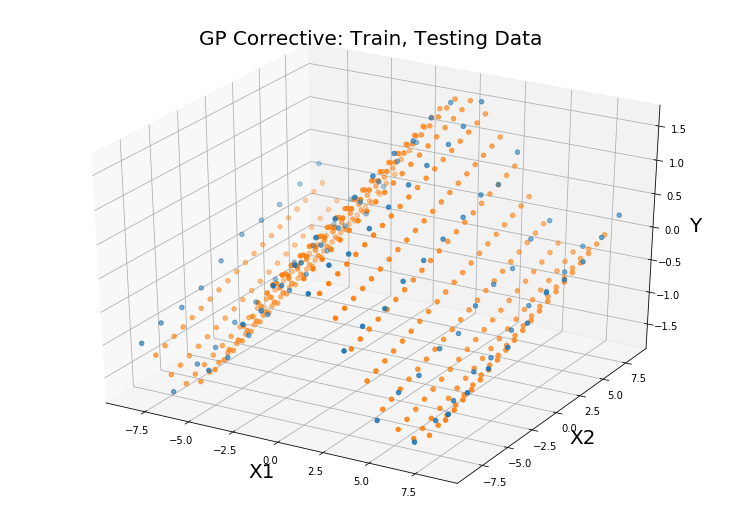

In [34]:
predictions['simple'], variance['simple'] = gp_model.estimate_many(x_plot)

fig, ax = plt.subplots(figsize=(10, 7))

ax = axes3d.Axes3D(fig)

ax.scatter3D(x_train[:, 0], x_train[:, 1], y_train)
ax.scatter3D(x_plot[:, 0], x_plot[:, 1], predictions['simple'])


ax.set_title('GP Corrective: Train, Testing Data', fontsize=20)
ax.set_xlabel('X1', fontsize=20)
ax.set_ylabel('X2', fontsize=20)
ax.set_zlabel('Y', fontsize=20)

plt.show()

## Exact GP Uncertainty

## Approximate GP Uncertainty

## Numerical (MC) GP Uncertainty

## Numerical (Gauss-Hermite) GP Uncertainty

### GP: Corrective Derivative Kernel

### Corrective Derivative Term

\begin{equation}
\nu(u, \Sigma_x) = \sigma^2(u) + \Sigma_{i,j=1}^{N} K_{i,j}^{-1} \cdot K(u, x_{i}) \cdot K(u, x_{j}) \cdot \left(1 - H(u, \bar{x}) \right) + \Sigma_{i,j=1}^{N} \beta_i \cdot \beta_j \cdot K(u, x_{i}) \cdot K(u, x_{j}) \cdot \left[ H(u, \bar{x}) - H(u, x_i) \cdot H(u, x_j) \right]
\end{equation}

where:

\begin{equation}
    H(u, \bar{x}) = \left| \left( \frac{W}{2} \right)^{-1} \Sigma_x + I \right|^{-1/2} \text{exp}
    \left[ \frac{1}{2}(u-\bar{x})^T \Delta^{-1} (u - \bar{x}) \right]
\end{equation}

* $\Delta^{-1} = \left( \frac{W}{2} \right)^{-1} \left[ \left( \frac{W}{2} \right)^{-1} + \Sigma_x^{-1} \right]^{-1/2} \left( \frac{W}{2} \right)^{-1}$
* $\bar{x} = \frac{x_i + x_j}{2}$

#### GP w/ Derivative Corrective Term

In [10]:
@numba.jit(nopython=True, nogil=True)
def calculate_q_numba(x_train, x_test, K, det_term, exp_scale):
    """Calculates the Q matrix used to compute the variance of the
    inputs with a noise covariance matrix. This uses numba to 
    speed up the calculations.
    
    Parameters
    ----------
    x_train : array, (n_samples x d_dimensions)
        The data used to train the weights.
    
    x_test : array, (d_dimensions)
        A vector of test points.
        
    K : array, (n_samples)
        The portion of the kernel matrix of the training points at 
        test point i, e.g. K = full_kernel_mat[:, i_test]
        
    det_term : float
        The determinant term that's in from of the exponent
        term.
        
    exp_scale : array, (d_dimensions)
        The length_scale that's used within the exponential term.
        
    Returns
    -------
    Q : array, (n_samples x n_samples)
        The Q matrix used to calculate the variance of the samples.
        
    Information
    -----------
    Author : J. Emmanuel Johnson
    Email  : jemanjohnson34@gmail.com
    Date   : 13 - 06 - 2018
    
    References
    ----------
    McHutchen et al. - Gaussian Process Training with Input Noise
    http://mlg.eng.cam.ac.uk/pub/pdf/MchRas11.pdf
    """
    n_train, d_dimensions = x_train.shape
    
    Q = np.zeros(shape=(n_train, n_train), dtype=np.float64)
    
    # Loop through the row terms
    for iterrow in range(n_train):
        
        # Calculate the row terms
        x_train_row = 0.5 * x_train[iterrow, :]  - x_test
        
        K_row = K[iterrow] * det_term
        
        # Loop through column terms
        for itercol in range(n_train):
            
            # Z Term
            z_term = x_train_row + 0.5 * x_train[itercol, :]
            
            # EXPONENTIAL TERM
            exp_term = np.exp( np.sum( z_term**2 * exp_scale) )
            
            # CONSTANT TERM
            constant_term = K_row * K[itercol] 
            
            # Q Matrix (Corrective Gaussian Kernel)
            Q[iterrow, itercol] = constant_term * exp_term
            
    return Q

In [11]:

class GP_Corrective(object):
    def __init__(self, length_scale=None, x_covariance=1.0, sigma_y=None, scale=None):
        self.length_scale = length_scale
        self.x_covariance = x_covariance
        self.sigma_y = sigma_y
        self.scale = scale
        
    def fit(self, x, y):
        
        # check input dimensions
        x_train, y_train = check_X_y(x, y)
        
        self.n_train, self.d_dim = x_train.shape
        
        
        self.length_scale = _check_length_scale(x, self.length_scale)
        self.x_covariance = _check_length_scale(x, self.x_covariance)
        
        if np.ndim(self.length_scale) == 0:
            self.length_scale = np.array([self.length_scale])
            
        if np.ndim(self.x_covariance) == 0:
            self.x_covariance = np.array([self.x_covariance])
            
        # check if length scale and sigma y are there
        if self.sigma_y is None:            
            self.length_scale, self.sigma_y = fit_gp(x_train, y_train, n_restarts=0)
        
            
        if self.scale is None:
            self.scale = 1.0
            
        # Calculate the training Kernel (ARD)
        K_train = ard_kernel(x_train, length_scale=self.length_scale, scale=self.scale)
        
        # Calculate the derivative
        derivative = self._calculate_derivative(x_train, y_train, K_train)

        # Add white noise kernel and derivative term
        derivative_term = np.diag(np.diag(derivative.dot(np.diag(self.x_covariance)).dot(derivative.T)))
        
        K_train += self.sigma_y**2 * np.eye(N=self.n_train) + derivative_term
            
        K_train_inv = np.linalg.inv(K_train)
        
        # Calculate the weights
        weights = K_train_inv.dot(y_train)
        
        # save variables
        self.x_train = x_train
        self.y_train = y_train
        self.K_ = K_train
        self.K_inv_ = K_train_inv
        self.derivative_ = derivative
        self.weights_ = weights
        
        return self
    
    def predict(self, x, return_std=False):
        
        x_test = check_array(x)
        
        # Calculate the weights
        K_traintest = ard_kernel_weighted(x_test, self.x_train, 
                                          x_cov=self.x_covariance, 
                                          length_scale=self.length_scale)
            
        if not return_std:
            return K_traintest.dot(self.weights_)
        
        else:
            predictions = K_traintest.dot(self.weights_)
            variance = self._calculate_variance(x_test, predictions=predictions)
            return predictions, variance
        
        
    def _calculate_derivative(self, x, y, K_train=None):
        
        # Calculate the training Kernel (ARD)
        if K_train is None:
            K_train = ard_kernel(x, length_scale=self.length_scale, scale=self.scale)

        # Calculate the weights for the initial kernel
        L = np.linalg.cholesky(K_train + self.sigma_y**2 * np.eye(self.n_train))
        initial_weights = np.linalg.solve(L.T, np.linalg.solve(L, y))[:, np.newaxis]
        self.der_weights_ = initial_weights
        
        # Calculate the derivative        
        return ard_derivative(x, x, weights=initial_weights, length_scale=self.length_scale)
    
    def _calculate_variance(self, x, predictions=None):
        
        x_test = check_array(x)
        n_test = x_test.shape[0]
        
        if predictions is None:
            predictions = self.predict(x_test, return_std=False)

        # Determinant Term
        det_term = 2 * self.x_covariance * np.power(self.length_scale, -2) + 1
        det_term = 1 / np.sqrt(np.linalg.det(np.diag(det_term)))
        
        # Exponential Term
        exp_scale = np.power(np.power(self.length_scale, 2) 
                             + 0.5 * np.power(self.length_scale, 4) 
                             * np.power(self.x_covariance, -1), -1)
                
        K = ard_kernel(self.x_train, x_test, length_scale=self.length_scale)
        
        
        variance = np.zeros(shape=(n_test))
        trace_term = variance.copy()
        q_weight_term = variance.copy()
        pred_term = variance.copy()
        
        # Loop through test points
        for itertest in range(n_test):
            
            # Calculate Q matrix
            Q = calculate_q_numba(self.x_train, x_test[itertest, :], K[:, itertest], det_term, exp_scale)
            
            # Terms
            trace_term[itertest] = float(np.trace(np.dot(self.K_inv_, Q)))
            q_weight_term[itertest] = float(self.weights_.T.dot(Q).dot(self.weights_))
            pred_term[itertest] = float(predictions[itertest]**2)
            # calculate the final predictive variance
            variance[itertest] = self.scale - trace_term[itertest] + \
                q_weight_term[itertest] - pred_term[itertest]
        
        # Negative variances due to numerical issues.
        # Set those variances to 0.
        var_negative = variance < 0
        if np.any(var_negative):
            warnings.warn("Predicted variances smaller than 0. "
                          "Setting those varinaces to 0.")
            
            variance[var_negative] = 0.0
        return variance

In [12]:
def ard_kernel_weighted(x, y=None, x_cov=None, length_scale=None, scale=None):
    
    # check if x, y have the same shape
    if y is not None:
        x, y = check_pairwise_arrays(x, y)
        
    # grab samples and dimensions
    n_samples, n_dimensions = x.shape
    
    # get the default sigma values
    if length_scale is None:
        length_scale = np.ones(shape=n_dimensions)
        
    else:
        length_scale = _check_length_scale(x, length_scale)
        
    # check covariance values
    if x_cov is None:
        x_cov = 0.0
    else:
        x_cov = _check_length_scale(x, x_cov)
        
    # Add dimensions to lengthscale and x_cov
    if np.ndim(length_scale) == 0:
        length_scale = np.array([length_scale])
        
    if np.ndim(x_cov) == 0:
        x_cov = np.array([x_cov])
        
    # get default scale values
    if scale is None:
        scale = 1.0
        

    exp_scale = np.sqrt(x_cov + length_scale**2)
    
    scale_term = np.diag(x_cov * (length_scale**2)**(-1)) + np.eye(N=n_dimensions)
    scale_term = np.linalg.det(scale_term)
    scale_term = np.power(scale_term, -1/2) 
    
    if y is None:
        dists = pdist(x / exp_scale, metric='sqeuclidean')
        
        K = np.exp(- 0.5 * dists)
        
        K = squareform(K)
        
        np.fill_diagonal(K, 1)
        
        K *= scale_term
        
    else:
        
        dists = cdist(x / exp_scale, y / exp_scale, metric='sqeuclidean')
        
        K = np.exp(- 0.5 * dists)

        K *= scale_term
    
    return K

In [15]:
%%time 

# Initialize GP
gp_error = GP_Corrective(length_scale=length_scale,
                       x_covariance=x_cov,
                       sigma_y=sigma_y)

# Fit the model
gp_error.fit(x_train, y_train.ravel());

# Predict
mean_,  var = gp_error.predict(x_test, return_std=True)

scores_ = mean_absolute_error(mean_, y_test)
print('\nMAE Score: {:.5f}\n'.format(scores_))
print(var.min(), var.max())


MAE Score: 0.01054

0.0004758704518568616 0.0006886328001329822
CPU times: user 3min 14s, sys: 21min 21s, total: 24min 36s
Wall time: 1min 2s


In [16]:
print(gp_error.derivative_.shape)

(400, 2)


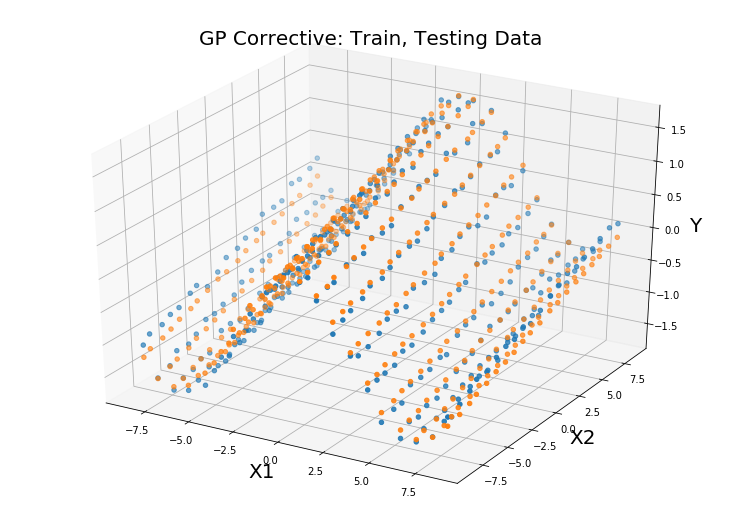

In [17]:
fig, ax = plt.subplots(figsize=(10, 7))

ax = axes3d.Axes3D(fig)

ax.scatter3D(x_train[:, 0], x_train[:, 1], y_train)
ax.scatter3D(x_train[:, 0], x_train[:, 1], mean_)


ax.set_title('GP Corrective: Train, Testing Data', fontsize=20)
ax.set_xlabel('X1', fontsize=20)
ax.set_ylabel('X2', fontsize=20)
ax.set_zlabel('Y', fontsize=20)

plt.show()

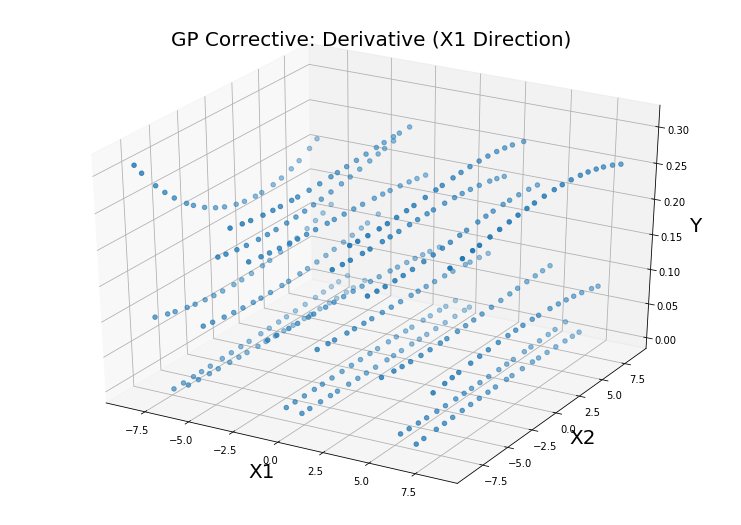

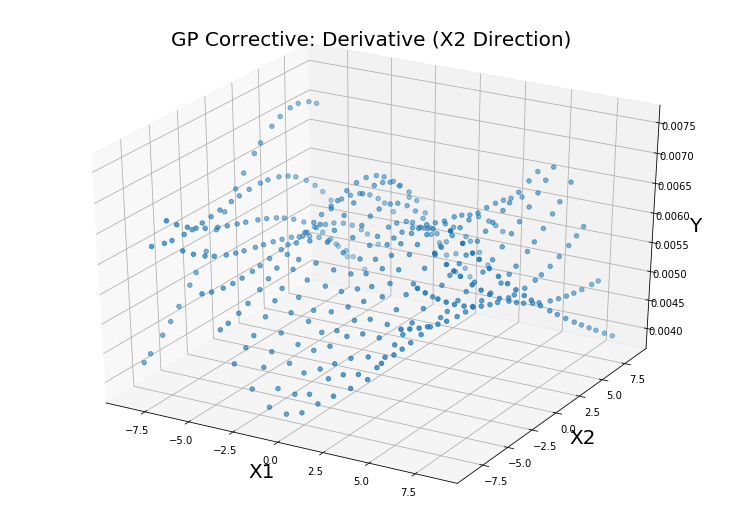

In [18]:
fig, ax = plt.subplots(figsize=(10, 7))

ax = axes3d.Axes3D(fig)

ax.scatter3D(x_train[:, 0], x_train[:, 1], gp_error.derivative_[:, 0]**2)

ax.set_title('GP Corrective: Derivative (X1 Direction)', fontsize=20)
ax.set_xlabel('X1', fontsize=20)
ax.set_ylabel('X2', fontsize=20)
ax.set_zlabel('Y', fontsize=20)

plt.show()

fig, ax = plt.subplots(figsize=(10, 7))

ax = axes3d.Axes3D(fig)

ax.scatter3D(x_train[:, 0], x_train[:, 1], gp_error.derivative_[:, 1]**2)

ax.set_title('GP Corrective: Derivative (X2 Direction)', fontsize=20)
ax.set_xlabel('X1', fontsize=20)
ax.set_ylabel('X2', fontsize=20)
ax.set_zlabel('Y', fontsize=20)

plt.show()

In [19]:
%%time 

# Predictions
predictions['corrective'], variance['corrective'] = gp_error.predict(x_plot, return_std=True)

# Standard Deviation
std_ = np.sqrt(variance['corrective'])

CPU times: user 10min 50s, sys: 2h 6min 36s, total: 2h 17min 26s
Wall time: 5min 44s


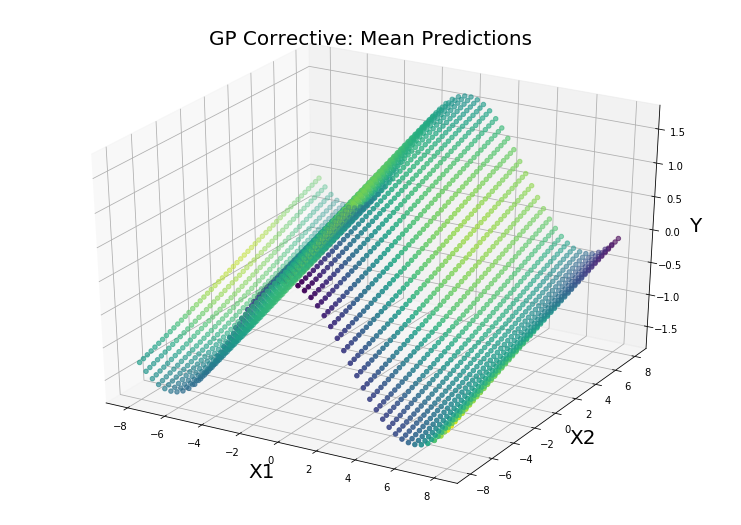

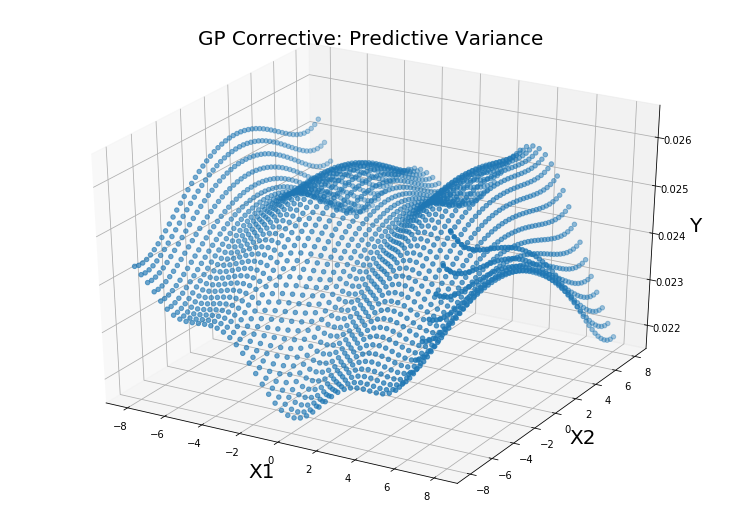

In [20]:


# -------------------
# LEARNED GP FUNCTION
# -------------------


fig, ax = plt.subplots(figsize=(10, 7))

ax = axes3d.Axes3D(fig)

ax.scatter3D(x_plot[:, 0], x_plot[:, 1], predictions['corrective'], c=std_)

ax.set_title('GP Corrective: Mean Predictions', fontsize=20)
ax.set_xlabel('X1', fontsize=20)
ax.set_ylabel('X2', fontsize=20)
ax.set_zlabel('Y', fontsize=20)

plt.show()

save_name = 'gp_derivative_term.png'

fig.savefig(figure_location + save_name, bbox_inhces='tight')


#-----------------------
# VARIANCE
# ----------------------

fig, ax = plt.subplots(figsize=(10, 7))

ax = axes3d.Axes3D(fig)

ax.scatter3D(x_plot[:, 0], x_plot[:, 1], np.sqrt(variance['corrective']))

ax.set_title('GP Corrective: Predictive Variance', fontsize=20)
ax.set_xlabel('X1', fontsize=20)
ax.set_ylabel('X2', fontsize=20)
ax.set_zlabel('Y', fontsize=20)

plt.show()

save_name = 'gp_derivative_term_var.png'

fig.savefig(figure_location + save_name, bbox_inhces='tight')

### Calculate the Empirical Variance (Get Scores)

In [21]:
# dx_plot = ard_derivative(x_train, X, weights=weights['original'], length_scale=length_scale)
# dx_plot = dx_plot**2
# x_pred_plot = X.squeeze()

# Grab Predictions
pred_der_kern = predictions['corrective'].squeeze()

# Grab Variances
var_der_kern = variance['corrective'].squeeze()

# Grab Standard Deviations
std_der_kern = np.sqrt(var_der_kern)

In [22]:
%%time

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae_score = {
    'simple': list(),
    'derivative': list(),
    'kernel': list(),
    'der_kernel': list(),
    'corrective': list()
}

mse_score = {
    'simple': list(),
    'derivative': list(),
    'kernel': list(),
    'der_kernel': list(),
    'corrective': list()
}

abs_error = {
    'original': list(),
    'derivative': list(),
    'corrective': list()
}
squared_error = {
    'original': list(),
    'derivative': list(),
    'corrective': list()
}

rng = np.random.RandomState(None)

# testing set (noise-less)
# sample data parameters
xe1_grid, xe2_grid = 100, 100

n_exp_trials = 100

xe1 = np.linspace(xt1_min, xt1_max, xe1_grid)
xe2 = np.linspace(xt2_min, xt2_max, xe2_grid)

Xe1, Xe2 = np.meshgrid(xe1, xe2)

Xe1, Xe2 = Xe1.flatten(), Xe2.flatten()

Xe = np.vstack((Xe1, Xe2)).T

y_etest = f(Xe)
y_etest = y_etest

for itrial in range(n_exp_trials):
    
    # Generate x and y test samples
    x_etest = np.vstack((Xe1 + x1_cov * rng.randn(Xe1.shape[0]),
                         Xe2 + x2_cov * rng.randn(Xe2.shape[0]))).T
    
    # ---------------------------------------
    # Calculate the Predictions and Variance
    # ---------------------------------------
    
    # Model III - Corrective Term
    mean = gp_error.predict(x_etest, return_std=False).squeeze()
    
    abs_error['corrective'].append(np.abs(mean - y_etest))
    squared_error['corrective'].append((mean - y_etest)**2) 
    mae_score['corrective'].append(mean_absolute_error(mean, y_etest))
    mse_score['corrective'].append(mean_squared_error(mean, y_etest))
    
# Make lists into arrays
abs_error['corrective'] = np.mean(np.array(abs_error['corrective']),
                                axis=0)
squared_error['corrective'] = np.mean(np.array(squared_error['corrective']),
                                    axis=0)
mae_score['corrective'] = np.mean(np.array(mae_score['corrective']))
mse_score['corrective'] = np.mean(np.array(mse_score['corrective']))

CPU times: user 29.8 s, sys: 5min 3s, total: 5min 33s
Wall time: 19 s


MSE: 0.00016
MAE: 0.01022


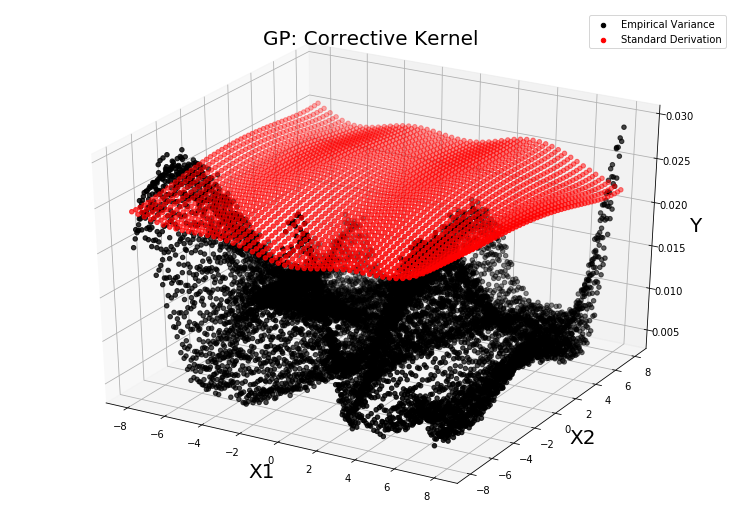

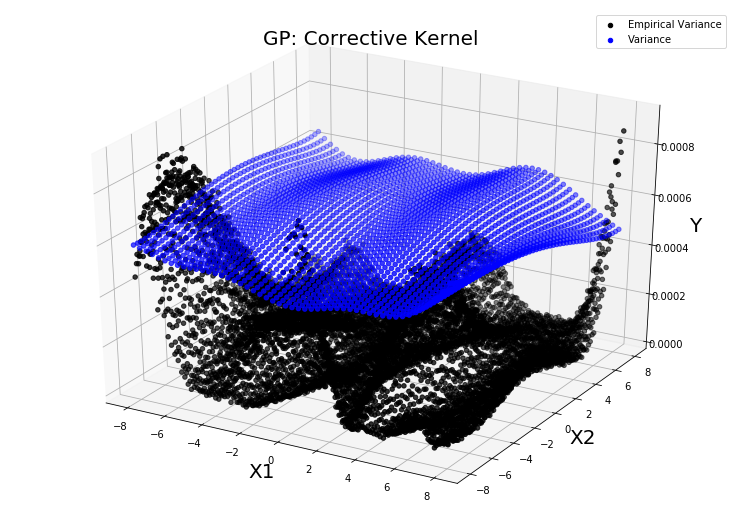

In [23]:
print('MSE: {:.5f}'.format(mse_score['corrective']))
print('MAE: {:.5f}'.format(mae_score['corrective']))

fig, ax = plt.subplots(figsize=(10, 7))

ax = axes3d.Axes3D(fig)

ax.scatter3D(Xe1, Xe2, abs_error['corrective'], color='k', label='Empirical Variance')
ax.scatter3D(x_plot[:, 0], x_plot[:, 1], std_der_kern, color='r', label='Standard Derivation')

ax.set_title('GP: Corrective Kernel', fontsize=20)
ax.set_xlabel('X1', fontsize=20)
ax.set_ylabel('X2', fontsize=20)
ax.set_zlabel('Y', fontsize=20)

ax.legend()
plt.show()

save_name = 'exp_empirical_corrective_std.png'
fig.savefig(figure_location + save_name, bbox_inches='tight')


fig, ax = plt.subplots(figsize=(10, 7))

ax = axes3d.Axes3D(fig)

ax.scatter3D(Xe1, Xe2, squared_error['corrective'], color='k', label='Empirical Variance')
ax.scatter3D(x_plot[:, 0], x_plot[:, 1], var_der_kern, color='b', label='Variance')


ax.set_title('GP: Corrective Kernel', fontsize=20)
ax.set_xlabel('X1', fontsize=20)
ax.set_ylabel('X2', fontsize=20)
ax.set_zlabel('Y', fontsize=20)

ax.legend()
plt.show()

save_name = 'exp_empirical_corrective_var.png'
fig.savefig(figure_location + save_name, bbox_inches='tight')